%%HTML
<table style="width:100%">
    <tr>
    <td style="text-align:right"><a target="_blanc" href="http://www.irt-saintexupery.com/"></a><img src="http://www.irt-saintexupery.com/wp-content/uploads/2015/05/logo.jpg"> </td>
    <td style="text-align:left"><a target="_blanc" href="http://www.irt-saintexupery.com/"></a><img src="http://www.enseeiht.fr/skins/enseeiht-new/resources/img/logo-enseeiht.png"> </td>
     </tr>
</table>
<center><h1>Devloppement du robot TwIRTee</h1></center>
<p text-align="right">
<table>
    <tr>
    <td>Tuteur :<br>Auteur :</td>
    <td style="text-align:right">Eric JENN<br>Sami EZZEROUALI</td>
    </tr>
</table>
</p>


## Simulation du modèle de positionnement par trilatération

In [33]:
import matplotlib.pyplot as plt
from numpy import *
from math import pi
from random import *


- La fonction anchorsPosition trace l'emplacement des beacons dans le cas de 4 émetteurs en positionnement carré [0,0] [0,1] [1,1] et [1,0]
##### TODO:	Rendre la fonction adaptable en nombre d'emetteurs, en suivant les methodes de placement évoqué dans "Roa et al. - 2007 - Optimal placement of sensors for trilateration Re"


In [34]:
def anchorsPosition(delta):
	_Xaux=[0,0,delta,delta]
	_Yaux=[0,delta,delta,0]
	_position=[_Xaux,_Yaux]
	return _position;

In [35]:
def drawCercles(vector,_R):
	teta=linspace(0,2*pi,720);
	cercles=[0,0]
	cx=[]
	cy=[]
	for k in range(len(vector[0])):
		for i in range(len(teta)):
			cx.append(vector[0][k]+_R[k]*sin(teta[i]))
			cy.append(vector[1][k]+_R[k]*cos(teta[i]))
	cercles=[cx,cy]
	return cercles

In [36]:
def robotMove():
    t=linspace(0,10,20)
    #x=150*sin(t)+60*t+200
    #y=100*t
    x=-500+250*t
    y=500+800*sin(t)
    robot=[]
    robot.append(x)
    robot.append(y)
    return robot

In [37]:
def rightRayons(position,vector):
    ray=[]
    for i in range(len(vector[1])):
        xyanchor=array((0,0))
        xyanchor[0]=vector[0][i]
        xyanchor[1]=vector[1][i]
        ray.append(linalg.norm(xyanchor-position))
    return ray

In [38]:
def distanceSensors(rate,ray):
	dvector=[]
	for i in range(len(ray)):
		dvector.append(ray[i]+randint(-int(ray[i]*rate)-1,int(ray[i]*rate+1)))
	return dvector;

In [39]:
vector=anchorsPosition(1000)

#plt.show()

mesuredRay=distanceSensors(0.1,ray)

robot=robotMove()


* 1er cas de figure :mesures parfaites

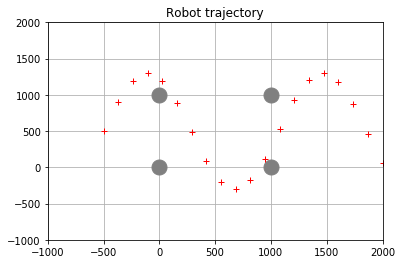

In [40]:
vector=anchorsPosition(1000)

plt.figure(1)
plt.title("Robot trajectory")
plt.plot(vector[0],vector[1],"o",markersize=15,color="gray")
plt.plot(robot[0],robot[1],"+",color="red")
plt.grid(True)
plt.ylim(-1000,2000)
plt.xlim(-1000,2000)
plt.show()

# Case 0 : 100% accurate data from DecaWave sensors 
* in this case, cercles intersect in one and only one point, then the position is unique

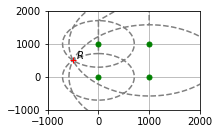

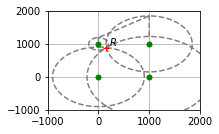

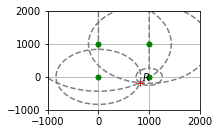

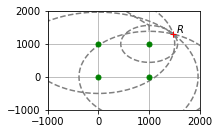

In [41]:

plt.figure(2)
plt.title("Cas parfait de la méthode de trilatération")
i=221
for j in range(4):
    plt.subplot(i+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])
    ray=rightRayons(position,vector)
    cercles = drawCercles(vector,ray)
    plt.plot(cercles[0],cercles[1],"--",color="gray")
    plt.text(robot[0][5*j]+50,robot[1][5*j]+50, r'$ R $')
    plt.plot(vector[0],vector[1],"o",markersize=5,color="green")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()

## Case 1 : we add some noise to distances

[-500.0, 500.0]


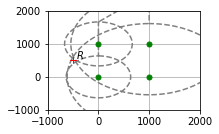

[157.8947368421052, 890.5513670931807]


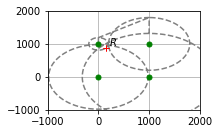

[815.7894736842104, -181.69789469470356]


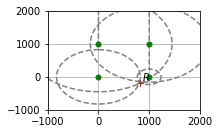

[1473.6842105263156, 1299.335697161588]


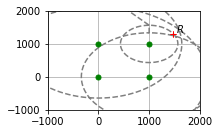

In [42]:

plt.figure(3)
plt.title("Cas parfait de la méthode de trilatération")
i=221
for j in range(4):
    plt.subplot(i+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])
    print(position)
    ray=rightRayons(position,vector)
    mesuredRay=distanceSensors(0.1,ray)
    cercles = drawCercles(vector,mesuredRay)
    plt.plot(cercles[0],cercles[1],"--",color="gray")
    plt.text(robot[0][5*j]+50,robot[1][5*j]+50, r'$ R $')
    plt.plot(vector[0],vector[1],"o",markersize=5,color="green")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()
    

circles do not intersect in one point 
# To Solve this issue, we will try the optimisation methods below :
## overdetermined linear systems :
* Least squares : it must compute the X,Y cordinate according to A and b matrix using QR decomposition method


In [43]:
def leastSquare(A,b):
    x=linalg.lstsq(A,b)
    return x

In [44]:
%%html 
<span></span>
<span>ComputeXY() : this function must compute the A and b matrix of the robot's coordinates according to Ray[] and anchorsVector
</span>


ComputeXY() : this function must compute the A and b matrix of the robot's coordinates according to Ray[] and anchorsVector

In [45]:
def computeXY(ray,anchorsVector):
    #print(ray)
    position=[0,0]
    _x=anchorsVector[0]
    _y=anchorsVector[1]
    A=[]
    for i in range(1,len(_x)):
        A.append([_x[i]-_x[0],_y[i]-_y[0]])
    #print(A)
    b=[]
    for i in range(1,len(ray)):
        b.append(0.5*(ray[0]**2-ray[i]**2+(_x[i]-_x[0])**2+(_y[i]-_y[0])**2))
    #print(b)
    position=leastSquare(A,b)
    return position

x=computeXY(mesuredRay,vector)
x[0]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


array([1831.41161984, 1374.17489402])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


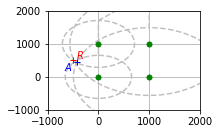

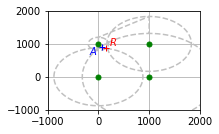

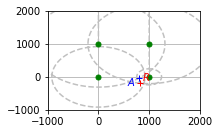

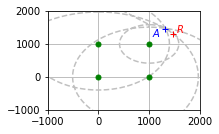

In [65]:


plt.figure(3)
plt.title("Cas parfait de la méthode de trilatération")
i=221
for j in range(4):
    plt.subplot(i+j)
    position=[]
    position.append(robot[0][5*j])
    position.append(robot[1][5*j])

    ray=rightRayons(position,vector);
    mesuredRay=distanceSensors(0.1,ray);
    aprox=computeXY(mesuredRay,vector);
    cercles = drawCercles(vector,mesuredRay);    
    
    plt.plot(cercles[0],cercles[1],"--",color="silver")
    plt.plot(vector[0],vector[1],"o",markersize=5,color="Green")
    plt.text(robot[0][5*j]+50,robot[1][5*j]+50, r'$ R $',color="red")
    plt.plot(robot[0][5*j],robot[1][5*j],"+",color="red")
    plt.text(aprox[0][0]-250,aprox[0][1]-250, r'$ A $',color="blue")
    plt.plot(aprox[0][0],aprox[0][1],"+",color="blue")
    
    #print(aprox)
    
    plt.ylim(-1000,2000)
    plt.xlim(-1000,2000)
    plt.grid(True)
    plt.show()
    

In [0]:
* We see that points have almost the same coordinates, 